# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

***
# Setup
***
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/FAIR-Universe/HEP-Challenge.git
    !pip install iminuit

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

`USE_PUBLIC_DATA` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [3]:
USE_PUBLIC_DATA = True

In [4]:
# if USE_PUBLIC_DATA:
    
#     # Download public data -- uncomment the next line to download public data (> 1 GB)
#     !wget -O public_data.zip https://www.codabench.org/datasets/download/c73d1b99-e767-428e-a076-df16a7c95e10/
    
#     # Unzip public data -- uncomment the next line to unzip the public data
#     !unzip public_data.zip -d public_data

***
# Existing Submissions
***
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

***
# Imports
***

In [5]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
warnings.filterwarnings("ignore")

***
# Directories
***

In [6]:
import os
root_dir = "./"
# Input data directory to read training data from
if USE_PUBLIC_DATA:
    input_dir = os.path.join(root_dir, "public_data","input_data")
    reference_dir = os.path.join(root_dir, "public_data","reference_data")
else:
    input_dir = os.path.join(root_dir, "input_data")
    reference_dir = os.path.join(root_dir, "reference_data")
# Output data directory to write predictions to
output_dir = os.path.join(root_dir, "sample_result_submission")
# Program directory
program_dir = os.path.join(root_dir, "ingestion_program")
# Score directory
score_dir = os.path.join(root_dir, "scoring_program")
# Directory to read submitted submissions from
submission_dir = os.path.join(root_dir, "sample_code_submission")


***
# Add directories to path
***

In [7]:
path.append(input_dir)
path.append(reference_dir)
path.append(output_dir)
path.append(program_dir)
path.append(submission_dir)

***
# Internal imports
***

In [8]:
from visualization import *
from systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [9]:
from model import Model
from config import CSV, PARQUET  # might change based on final data format
USE_RANDOM_MUS = True

***
# Data
***
1. Load Train set
2. Load Test sets


### ⚠️ Note:
The data used here is sample data is for demonstration only to get a view of what the data looks like.

In [10]:
from frozendict import frozendict
test_set_settings = None

class Data:

    def __init__(self):

        self.__train_set = None
        self.__test_set = None
        self.systematics = systematics
        self.NUM_SETS = 4

        print("==========================================")
        print("Data")
        print("==========================================")

    def load_train_set(self):
        print("[*] Loading Train data")

        if CSV:
            train_data_file = os.path.join(input_dir, "train", "data", "data.csv")
        if PARQUET:
            train_data_file = os.path.join(input_dir, "train", "data", "data.parquet")
        train_labels_file = os.path.join(input_dir, "train", "labels", "data.labels")
        train_settings_file = os.path.join(input_dir, "train", "settings", "data.json")
        train_weights_file = os.path.join(input_dir, "train", "weights", "data.weights")
        train_detailed_labels_file = os.path.join(
            input_dir, "train", "detailed_labels", "data.detailed_labels"
        )

        # read train labels
        with open(train_labels_file, "r") as f:
            train_labels = np.array(f.read().splitlines(), dtype=float)

        # read train settings
        with open(train_settings_file) as f:
            train_settings = json.load(f)

        # read train weights
        with open(train_weights_file) as f:
            train_weights = np.array(f.read().splitlines(), dtype=float)

        # read train process flags
        with open(train_detailed_labels_file) as f:
            train_detailed_labels = f.read().splitlines()

        if PARQUET:
            self.__train_set = frozendict(
                {
                    "data": pd.read_parquet(train_data_file, engine="pyarrow"),
                    "labels": train_labels,
                    "settings": train_settings,
                    "weights": train_weights,
                    "detailed_labels": train_detailed_labels,
                }
            )
        else:
            self.__train_set = frozendict(
                {
                    "data": pd.read_csv(train_data_file),
                    "labels": train_labels,
                    "settings": train_settings,
                    "weights": train_weights,
                    "detailed_labels": train_detailed_labels,
                }
            )

        del train_labels, train_settings, train_weights, train_detailed_labels

        print(self.__train_set["data"].info(verbose=False, memory_usage="deep"))
        print("[*] Train data loaded successfully")

    def load_test_set(self):
        print("[*] Loading Test data")

        test_data_dir = os.path.join(input_dir, "test", "data")
        test_settings_file = os.path.join(test_data_dir, "settings", "data.json")

        # read test settings
        if USE_RANDOM_MUS:
            self.test_settings = {
                "ground_truth_mus": (np.random.uniform(0.1, 3, self.NUM_SETS)).tolist()
            }
            random_settings_file = os.path.join(output_dir, "random_mu.json")
            with open(random_settings_file, "w") as f:
                json.dump(self.test_settings, f)
        else:
            with open(test_settings_file) as f:
                self.test_settings = json.load(f)
                
        test_set = {
            "ztautau": pd.DataFrame(),
            "wjets": pd.DataFrame(),
            "diboson": pd.DataFrame(),
            "ttbar": pd.DataFrame(),
            "htautau": pd.DataFrame(),
        }

        for key in test_set.keys():
            if CSV:
                test_data_path = os.path.join(test_data_dir, f"{key}_data.csv")
                test_set[key] = pd.read_csv(test_data_path)

            if PARQUET:
                test_data_path = os.path.join(test_data_dir, f"{key}_data.parquet")
                test_set[key] = pd.read_parquet(test_data_path, engine="pyarrow")

        self.__test_set = frozendict(test_set)
        print("[*] Test data loaded successfully")

    def get_train_set(self):
        return self.__train_set

    def get_test_set(self):
        return self.__test_set

In [11]:
# Initilaize data
data = Data()

Data


In [12]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575097 entries, 0 to 575096
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float64(27), int64(1)
memory usage: 122.9 MB
None
[*] Train data loaded successfully


In [13]:
# load test sets
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [14]:
train_visualize = Dataset_visualise(
    data_set=data.get_train_set(),
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [15]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 575097
[*] --- Number of features : 28
[*] --- Number of signal events : 495551
[*] --- Number of background events : 79546
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,29.913,-0.308,-2.168,23.578,1.769,0.268,23.578,1.769,0.268,-7.000,...,36.476,-7.000,-7.000,-7.000,3.202,36.476,77.069,1.269,1.121,-7.000
1,41.251,0.925,1.536,24.691,1.191,0.488,223.840,2.683,-1.844,24.691,...,222.259,2.195,45.483,1.310,1.081,26.386,314.472,1.671,1.348,0.696
2,30.625,-0.689,0.123,44.955,-1.795,0.518,147.026,-1.473,2.397,45.284,...,201.555,3.812,98.538,-3.446,1.175,75.430,340.161,0.681,0.141,0.707
3,24.385,-0.649,2.554,25.602,-0.760,-0.413,25.602,-0.760,-0.413,-7.000,...,20.000,-7.000,-7.000,-7.000,2.970,20.000,75.588,0.952,1.406,-7.000
4,25.502,-2.074,1.534,26.348,0.080,-1.508,26.348,0.080,-1.508,22.788,...,8.807,0.629,-0.000,0.057,3.728,17.600,100.987,0.968,-1.395,0.000


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,...,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000
mean,41.587287,0.001249,-0.002408,51.980943,0.001700,0.002269,78.830276,0.000010,0.000237,36.990437,...,67.170691,-0.698906,10.923658,-2.100203,2.535985,51.966285,243.089911,0.948967,0.416845,-1.835261
std,25.250552,1.163580,1.813929,28.497721,1.196813,1.813250,60.044243,1.554488,1.813495,41.354321,...,70.612892,4.300686,30.965837,4.097096,0.708182,56.682335,161.085654,0.699222,1.124750,3.401444
min,20.000000,-2.500000,-3.142000,22.861000,-2.686000,-3.142000,22.919000,-4.924000,-3.142000,-7.000000,...,0.041000,-7.000000,-7.000000,-14.626000,0.518000,0.041000,66.679000,0.034000,-1.414000,-7.000000
25%,26.308000,-0.879000,-1.572000,34.565000,-0.914000,-1.566000,43.467000,-1.114000,-1.573000,-7.000000,...,19.064000,-7.000000,-7.000000,-7.000000,2.084000,15.574000,135.879000,0.533000,-0.896000,-7.000000
50%,34.371000,0.001000,-0.006000,45.473000,0.003000,0.008000,58.906000,0.002000,0.001000,34.154000,...,42.243000,0.962000,0.000000,-1.146000,2.756000,32.808000,189.560000,0.771000,1.048000,0.006000
75%,47.387000,0.883000,1.570000,59.839000,0.919000,1.570000,91.197000,1.114000,1.570000,55.607000,...,90.877000,2.385000,15.439000,0.632000,3.069000,70.742000,300.084000,1.132000,1.368000,0.568000
max,1026.430000,2.500000,3.142000,778.646000,2.681000,3.142000,1166.640000,4.924000,3.142000,696.237000,...,1167.007000,7.845000,817.350000,14.638000,5.829000,1797.446000,2939.478000,23.846000,1.414000,1.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

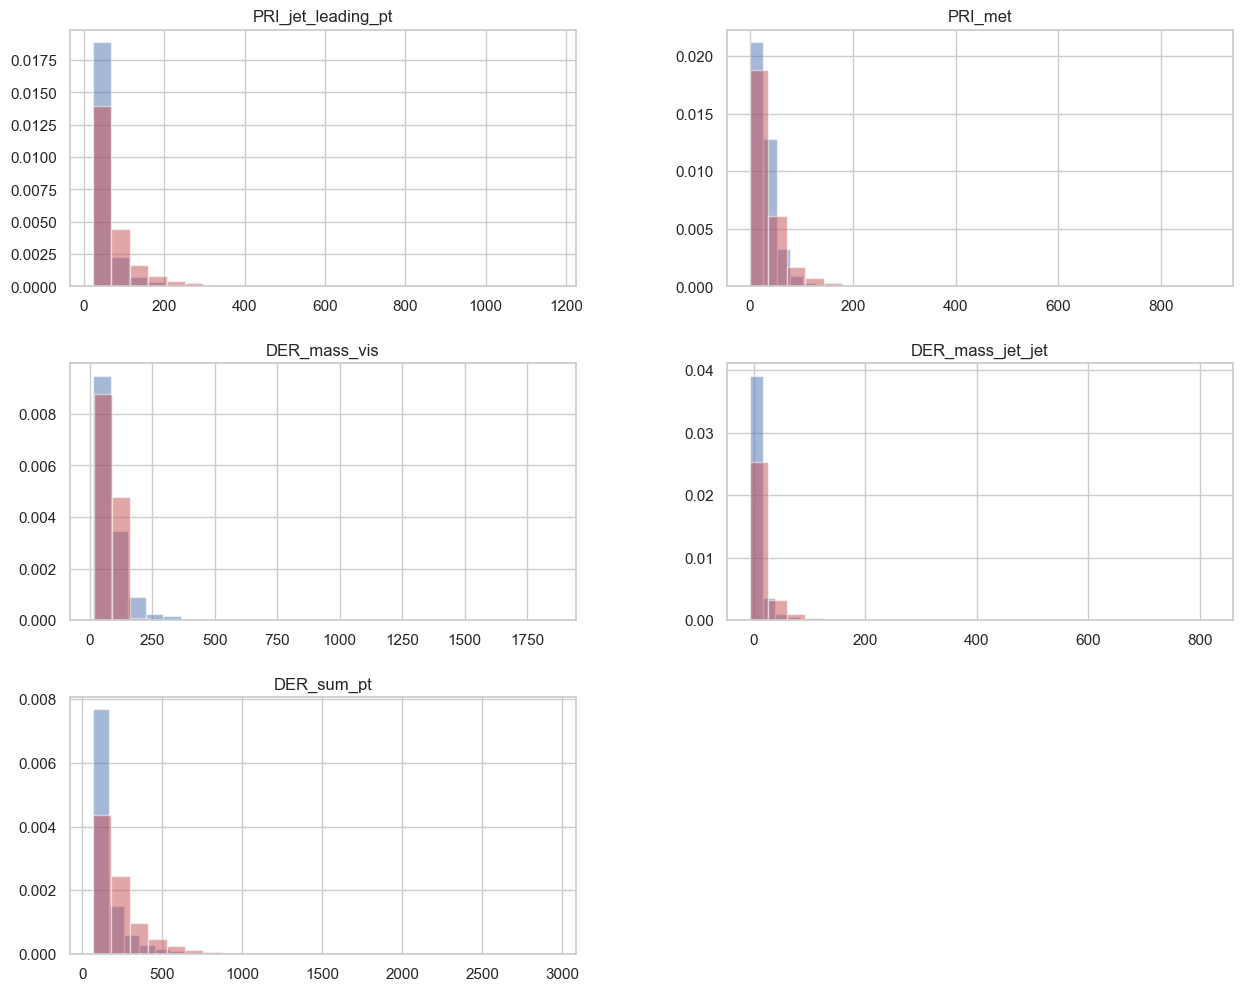

In [16]:
# Show data summary
train_visualize.histogram_dataset()

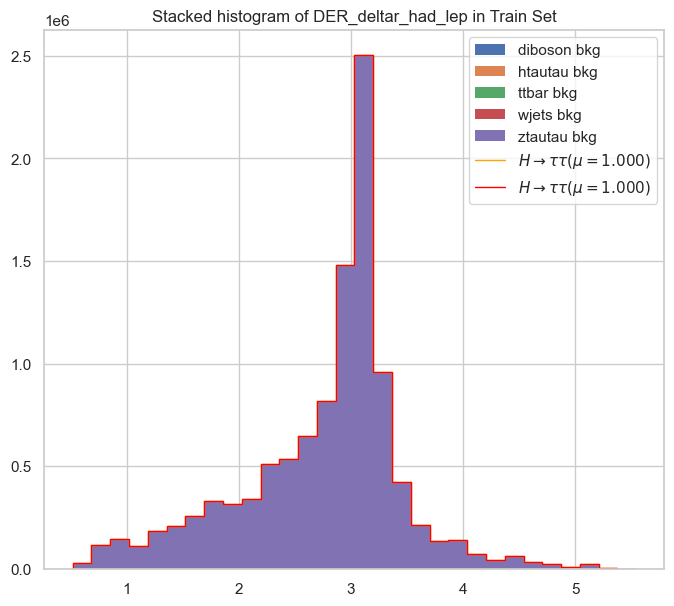

In [17]:
train_visualize.stacked_histogram("DER_deltar_had_lep")

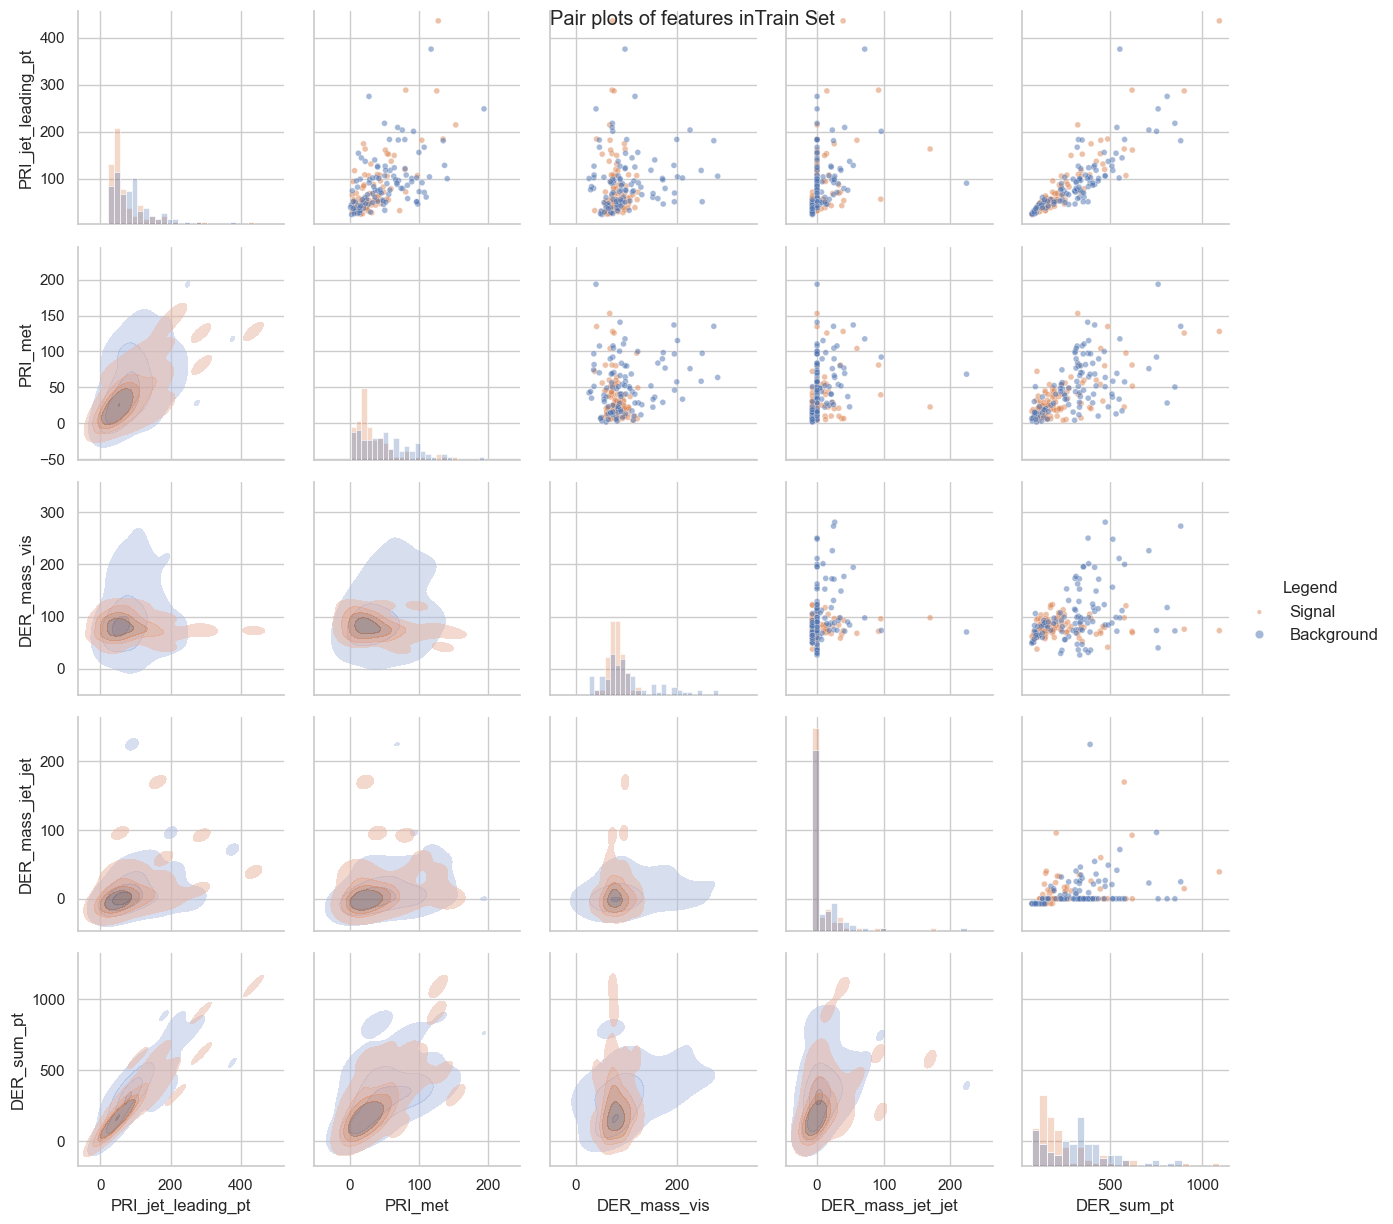

In [18]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

***
# Systematics
***
We demonstrate how `Systematics` class can be used to add systematics to a dataset

### ⚠️ Note:
`Systematics` class is one of the input of the submitted model, Participants are free to use this class and introduce systematics in their datasets

In [19]:
class Syst:
    def __init__(self, data):

        self.data = data
        self.columns = [
            "PRI_lep_pt",
            "PRI_lep_eta",
            "PRI_had_eta",
            "DER_deltar_had_lep",
        ]
        print("==========================================")
        print("Systematics")
        print("==========================================")

    def add_systematics_to_train_data(self):
        print("[*] Adding systematics to Train set")
        # generate tes value uniformly between 0.9 and 1.1
        tes = round(np.random.uniform(0.9, 1.10), 2)
        jes = round(np.random.uniform(0.9, 1.10), 2)
        soft_met = round(np.random.uniform(0.9, 1.10), 2)  # $ need to checked
        print(f"[*] --- tes: {tes}")
        print(f"[*] --- jes: {jes}")
        print(f"[*] --- soft_met: {soft_met}")
        # apply systematics
        self.train_set_with_systematics = systematics(
            data_set=self.data.get_train_set(),
            tes=tes,
            jes=jes,
            soft_met=soft_met,
        )

    def visualize_train_set_wrt_systematics(self,sample_size=100):
        print("[*] Visualizing Train set with systematics")
        pair_plots_syst(
            df=data.get_train_set()["data"],
            columns=self.columns,
            df_syst=self.train_set_with_systematics["data"],
            sample_size=sample_size,
        )

In [20]:
# Intiialize Program
syst = Syst(data=data)

Systematics


In [21]:
# Add systematics to trian data
syst.add_systematics_to_train_data()

[*] Adding systematics to Train set
[*] --- tes: 1.09
[*] --- jes: 1.05
[*] --- soft_met: 1.06


[*] Visualizing Train set with systematics


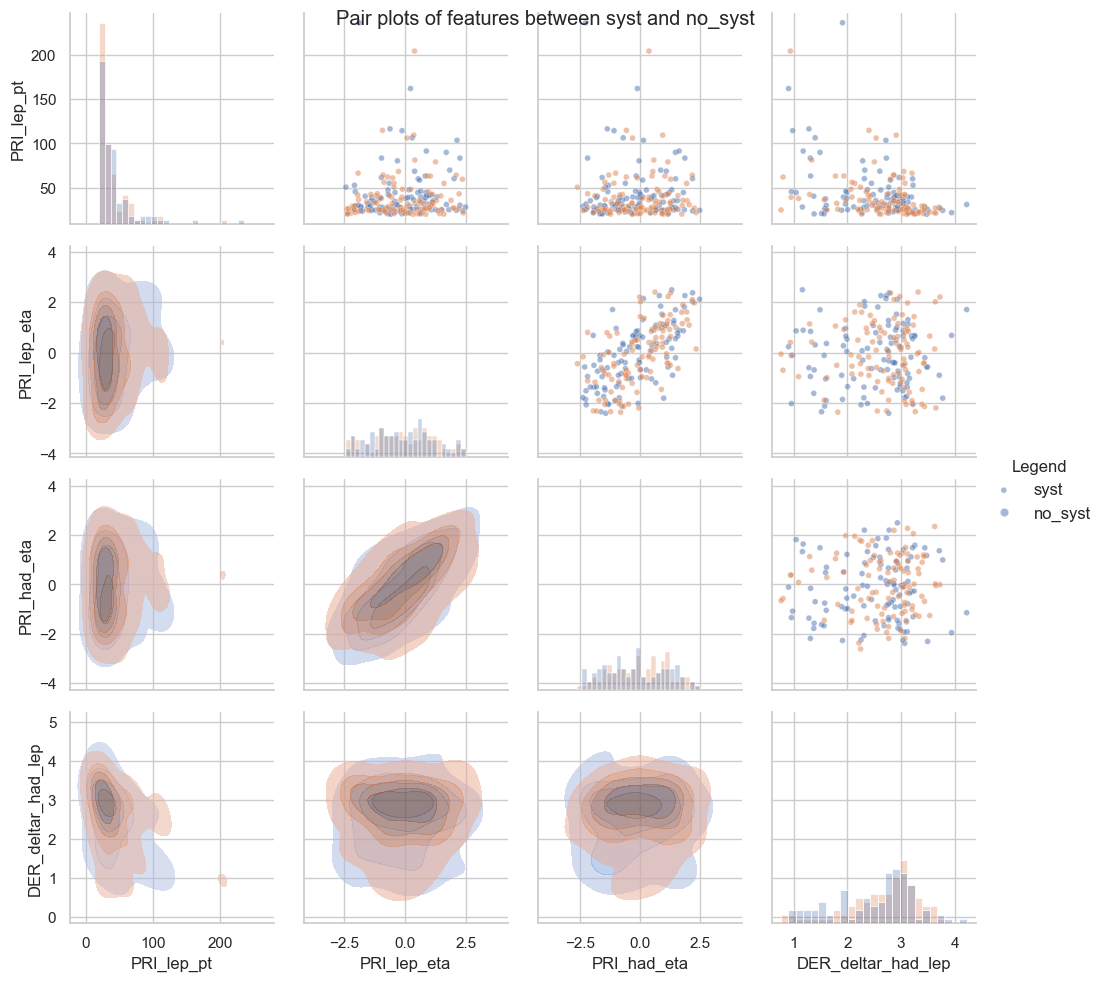

In [22]:
# Pair plots of train set with systematics
syst.visualize_train_set_wrt_systematics(sample_size=100)

***
# Program
***
**`Ingestion program`** is responsible to run the submission of a participant on Codabench platform. **`Program`** is a simplified version of the **Ingestion Program** to show to participants how it runs a submission.
1. Train a model on train data
2. Predict using Test data

In [23]:
class Program:

    def __init__(self, data):
        from systematics import get_bootstraped_dataset, get_systematics_dataset

        # used to keep object of Model class to run the submission
        self.model = None
        # object of Data class used here to get the train and test sets
        self.data = data
        self.test_set_settings = data.test_settings
        self._dict_systematics = {
            "tes": False,
            "jes": False,
            "soft_met": False,
            "w_scale": False,
            "bkg_scale": False,
        }

        # results
        self.results = []

        print("==========================================")
        print("Program")
        print("==========================================")

    def initialize_submission(self):
        print("[*] Initializing Submmited Model")
        self.model = Model(train_set=self.data.get_train_set(), systematics=systematics)

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        self.model.fit()


    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
        # get set inxex = 0
        set_indices = np.arange(0, 1)
        # get test set indices per set (0-99)
        test_set_indices = np.arange(0, 100)

        # create a product of set and test set indices all combinations of tuples
        all_combinations = list(product(set_indices, test_set_indices))

        results_dict = {}
        for set_index, test_set_index in all_combinations:

            # random tes value (one per test set)
            if self._dict_systematics["tes"]:
                tes = np.random.uniform(0.9, 1.1)
            else:
                tes = 1.0
            if self._dict_systematics["jes"]:
                jes = np.random.uniform(0.9, 1.1)
            else:
                jes = 1.0
            if self._dict_systematics["soft_met"]:
                soft_met = np.random.uniform(1.0, 5)
            else:
                soft_met = 1.0

            if self._dict_systematics["w_scale"]:
                w_scale = np.random.uniform(0.5, 2)
            else:
                w_scale = None

            if self._dict_systematics["bkg_scale"]:
                bkg_scale = np.random.uniform(0.5, 2)
            else:
                bkg_scale = None

            # create a seed
            seed = (set_index * 100) + test_set_index
            # get mu value of set from test settings
            set_mu = self.test_set_settings["ground_truth_mus"][set_index]

            from systematics import get_bootstraped_dataset, get_systematics_dataset

            # get bootstrapped dataset from the original test set
            pesudo_exp_data = get_bootstraped_dataset(
                self.data.get_test_set(),
                mu=set_mu,
                w_scale=w_scale,
                bkg_scale=bkg_scale,
                seed=seed,
            )
            test_set = get_systematics_dataset(
                pesudo_exp_data,
                tes=tes,
                jes=jes,
                soft_met=soft_met,
            )

            predicted_dict = self.model.predict(test_set)
            predicted_dict["test_set_index"] = test_set_index

            print(
                f"[*] - mu_hat: {predicted_dict['mu_hat']} - delta_mu_hat: {predicted_dict['delta_mu_hat']} - p16: {predicted_dict['p16']} - p84: {predicted_dict['p84']}"
            )

            if set_index not in results_dict:
                results_dict[set_index] = []

            results_dict[set_index].append(predicted_dict)

        # prepare results for scoring
        self.results = []
        for i in range(0, 1):
            set_result = results_dict[i]
            mu_hats, delta_mu_hats, p16, p84 = [], [], [], []
            for test_set_dict in set_result:
                mu_hats.append(test_set_dict["mu_hat"])
                delta_mu_hats.append(test_set_dict["delta_mu_hat"])
                p16.append(test_set_dict["p16"])
                p84.append(test_set_dict["p84"])

            ingestion_result_dict = {
                "mu_hats": mu_hats,
                "delta_mu_hats": delta_mu_hats,
                "p16": p16,
                "p84": p84,
            }
            self.results.append(ingestion_result_dict)

In [24]:
# Intiialize Program
program = Program(data=data)

Program


In [25]:
# Initialize submitted model
program.initialize_submission()

[*] Initializing Submmited Model
[*] --- length of fit_line_s_list: 30
[*] --- length of fit_line_b_list: 30


In [26]:
# Call fit method of submitted model
program.fit_submission()

[*] Calling fit method of submitted model


In [27]:
# Call predict method of submitted model
program.predict_submission()

[*] Calling predict method of submitted model


AttributeError: 'Program' object has no attribute 'test_set'

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [ ]:
class Score():

    def __init__(self, data, program):

        self.data = data
        self.program = program

        print("==========================================")
        print("Score")
        print("==========================================")

    def compute_scores(self):
        print("[*] Computing scores")

        # loop over ingestion results
        self.rmses, self.maes, self.p16, self.p84, self.mus, self.mu_hats, self.intervals, self.coverages, self.quantiles_scores = [], [], [], [], [], [], [], [], []
        all_mus, all_p16s, all_p84s = [], [], []
        for i, (ingestion_result, mu) in enumerate(zip(self.program.results, self.data.test_set["settings"]["ground_truth_mus"])):
            
            mu_hats = ingestion_result["mu_hats"]
            delta_mu_hats = ingestion_result["delta_mu_hats"]
            p16s = ingestion_result["p16"]
            p84s = ingestion_result["p84"]

            all_mus.extend(np.repeat(mu, len(p16s)))
            all_p16s.extend(p16s)
            all_p84s.extend(p84s)

            set_rmses, set_maes = [], []
            for mu_hat, delta_mu_hat in zip(mu_hats, delta_mu_hats):
                set_rmses.append(self.RMSE_score(mu, mu_hat, delta_mu_hat))
                set_maes.append(self.MAE_score(mu, mu_hat, delta_mu_hat))
            set_interval, set_coverage, set_quantiles_score = self.Quantiles_Score(np.repeat(mu, len(p16s)), np.array(p16s), np.array(p84s))

            set_mae = np.mean(set_maes)
            set_rmse = np.mean(set_rmses)

            print("------------------")
            print(f"Set {i}")
            print("------------------")
            print(f"MAE (avg): {set_mae}")
            print(f"RMSE (avg): {set_rmse}")
            print(f"Interval: {set_interval}")
            print(f"Coverage: {set_coverage}")
            print(f"Quantiles Score: {set_quantiles_score}")

            # Save set scores in lists
            self.mus.append(mu)
            self.p16.append(p16s)
            self.p84.append(p84s)
            self.mu_hats.append(mu_hats)
            self.rmses.append(set_rmse)
            self.maes.append(set_mae)
            self.intervals.append(set_interval)
            self.coverages.append(set_coverage)
            self.quantiles_scores.append(set_quantiles_score)

        overall_interval, overall_coverage, overall_quantiles_score = self.Quantiles_Score(np.array(all_mus), np.array(all_p16s), np.array(all_p84s))

        print("\n\n==================")
        print("Overall Score")
        print("==================")
        print(f"[*] --- RMSE: {round(np.mean(self.rmses), 3)}")
        print(f"[*] --- MAE: {round(np.mean(self.maes), 3)}")
        print(f"[*] --- Interval: {round(overall_interval, 3)}")
        print(f"[*] --- Coverage: {round(overall_coverage, 3)}")
        print(f"[*] --- Quantiles score: {round(overall_quantiles_score, 3)}")

    def RMSE_score(self, mu, mu_hat, delta_mu_hat):
        """Compute the sum of MSE and MSE2."""

        def MSE(mu, mu_hat):
            """Compute the mean squared error between scalar mu and vector mu_hat."""
            return np.mean((mu_hat - mu) ** 2)

        def MSE2(mu, mu_hat, delta_mu_hat):
            """Compute the mean squared error between computed delta_mu = mu_hat - mu and delta_mu_hat."""
            adjusted_diffs = (mu_hat - mu)**2 - delta_mu_hat**2
            return np.mean(adjusted_diffs**2)

        return np.sqrt(MSE(mu, mu_hat) + MSE2(mu, mu_hat, delta_mu_hat))

    def MAE_score(self, mu, mu_hat, delta_mu_hat):
        """Compute the sum of MAE and MAE2."""

        def MAE(mu, mu_hat):
            """Compute the mean absolute error between scalar mu and vector mu_hat."""
            return np.mean(np.abs(mu_hat - mu))

        def MAE2(mu, mu_hat, delta_mu_hat):
            """Compute the mean absolute error based on the provided definitions."""
            adjusted_diffs = np.abs(mu_hat - mu) - delta_mu_hat
            return np.mean(np.abs(adjusted_diffs))

        return MAE(mu, mu_hat) + MAE2(mu, mu_hat, delta_mu_hat)

    def Quantiles_Score(self, mu, p16, p84, eps=1e-3):

        def Interval(p16, p84):
            """Compute the average of the intervals defined by vectors p16 and p84."""
            return np.mean(np.abs(p84 - p16))

        def Coverage(mu, p16, p84):
            """Compute the fraction of times scalar mu is within intervals defined by vectors p16 and p84."""
            return_coverage = np.mean((mu >= p16) & (mu <= p84))
            return return_coverage

        def f(x, n_tries, max_coverage=1e4, one_sigma = 0.6827):
                sigma68 = np.sqrt(((1-one_sigma)*one_sigma*n_tries))/n_tries

                if (x >= one_sigma-2*sigma68 and x <= one_sigma+2*sigma68):
                    out = 1
                elif (x < one_sigma-2*sigma68):
                    out = 1 + abs((x-(one_sigma-2*sigma68))/sigma68)**4
                elif (x > one_sigma+2*sigma68):
                    out = 1 + abs((x-(one_sigma+2*sigma68))/sigma68)**3
                return out

        coverage = Coverage(mu, p16, p84)
        interval = Interval(p16, p84)
        score = -np.log((interval + eps) * f(coverage, n_tries=mu.shape[0]))
        return interval, coverage, score

    def visualize_scatter(self):
        plt.figure(figsize=(6, 4))
        for i, (ingestion_result, mu) in enumerate(zip(self.program.results, self.data.test_set["settings"]["ground_truth_mus"])):
           
            mu_hat = np.mean(ingestion_result["mu_hats"])
            plt.scatter(mu, mu_hat, c='b', marker='o')
        
        plt.xlabel('Ground Truth $\mu$')
        plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
        plt.title('Ground Truth vs. Predicted $\mu$ Values')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def visualize_coverage(self):

        fig = plt.figure( figsize=(5, 5))

        for idx, (mu, mu_hats, p16s, p84s) in enumerate(zip(self.mus, self.mu_hats, self.p16, self.p84)):

             # plot horizontal lines from p16 to p84
            for i, (p16, p84) in enumerate(zip(p16s, p84s)):
                plt.hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

            plt.vlines(x=mu, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed')
            plt.xlabel('mu')
            plt.ylabel('psuedo-experiments')
            plt.title(f'mu distribution - Set_{idx}')
            
        plt.show()


In [ ]:
# Initialize Score
score = Score(data=data, program=program)

In [ ]:
# Compute Score
score.compute_scores()

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
score.visualize_scatter()

In [ ]:
# Visualize coverage
score.visualize_coverage()

***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**
⚠️ Note: Ingestion program runs by default a small dataset. To run it on public data set `USE_PUBLIC_DATA = True`

In [ ]:
!python3 $program_dir/ingestion.py

### **Test Scoring Program**

In [ ]:
!python3 $score_dir/score.py

### **Prepare the submission**

In [ ]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'HiggsML-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")